# Visualization Notebook

In [3]:
%matplotlib inline
from new_methods.new_methods import My_NuScenes
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os.path as osp
import pythreejs as pjs
import pickle
import math as mt

nusc = My_NuScenes(version='v1.0-mini', dataroot='/data/datasets/nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.242 seconds.
Reverse indexing ...
Done reverse indexing in 0.0 seconds.


# Min_Max_Avg Graph

In [2]:
boundary = 3

In [3]:
total_dis = {'idx': [], 'max':[], 'min':[], 'avg':[]}

for i in tqdm(range(len(nusc.sample))):
    _, diff, _ = nusc.check_depth(nusc.sample[i]['token'], boundary=boundary)
    if len(diff)!=0:
        max = np.max(diff)
        min = np.min(diff)
        avg = np.sum(diff)/len(diff)
        total_dis['idx'].append(i)
        total_dis['max'].append(max)
        total_dis['min'].append(min)
        total_dis['avg'].append(avg)

100%|███████████████████████| 404/404 [00:24<00:00, 16.26it/s]


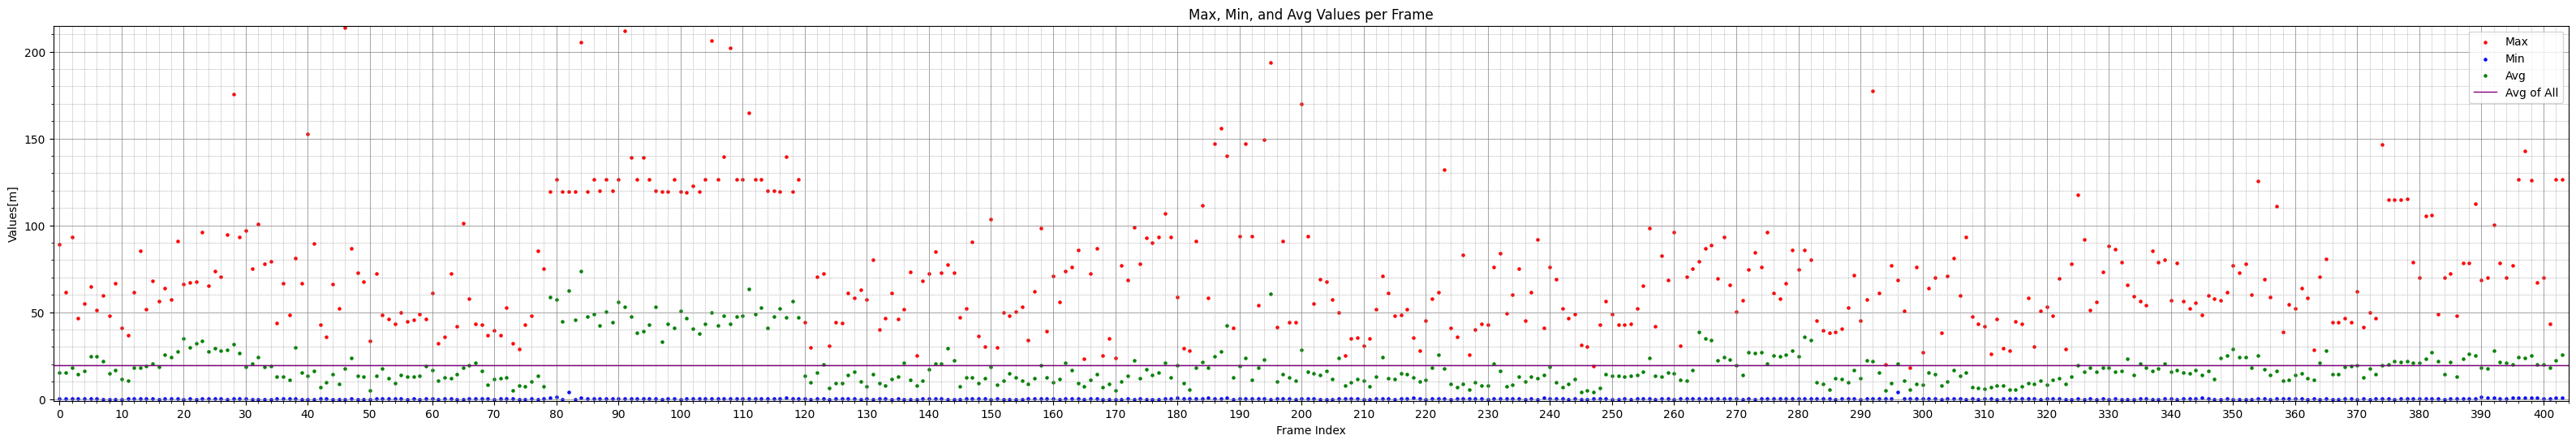

In [4]:
# 저장경로 설정
boundary_path = 'boundary_'+str(boundary)
base_path = '/home/byounghun/workspace/Nuscenes_tutorial/visualization/Graphs/'
if not osp.exists(base_path):
    os.makedirs(base_path)
file_name = 'Max_Min_Avg.png'
out_path = osp.join(base_path,boundary_path,file_name)

# total_dis에서 값 받아오기
idx = total_dis['idx']
max_values = total_dis['max']
min_values = total_dis['min']
avg_values = total_dis['avg']

avg_of_all = np.sum(avg_values)/len(avg_values)

# fig 생성
plt.figure(figsize=(40, 6))

# scatter
plt.scatter(idx, max_values, color='red', s=5, label='Max')  # Max 값은 빨간색
plt.scatter(idx, min_values, color='blue', s=5, label='Min')  # Min 값은 파란색
plt.scatter(idx, avg_values, color='green', s=5, label='Avg')  # Avg 값은 초록색
plt.axhline(y=avg_of_all, color='purple', linestyle='-', linewidth=1, label='Avg of All')

plt.title('Max, Min, and Avg Values per Frame')
plt.xlabel('Frame Index')
plt.xlim([np.min(idx)-1, np.max(idx)+1])
plt.ylabel('Values[m]')
plt.ylim([np.min(min_values)-1, np.max(max_values)+1])

plt.legend()

plt.grid(True)
plt.minorticks_on()

plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')  # 주 눈금에 대한 그리드
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')  # 보조 눈금에 대한 그리드

plt.xticks(np.arange(np.min(idx), np.max(idx)+1, 10))  # x축 눈금 간격 설정
plt.yticks(np.arange(np.min(min_values), np.max(max_values)+1, 50))  # y축 눈금 간격 설정

plt.savefig(out_path)

plt.show()

# Distribution of |radar depth - lidar depth| graph

In [137]:
boundary = 3
max_range = 200
index = 83

100%|███████████████████████| 404/404 [02:13<00:00,  3.04it/s]


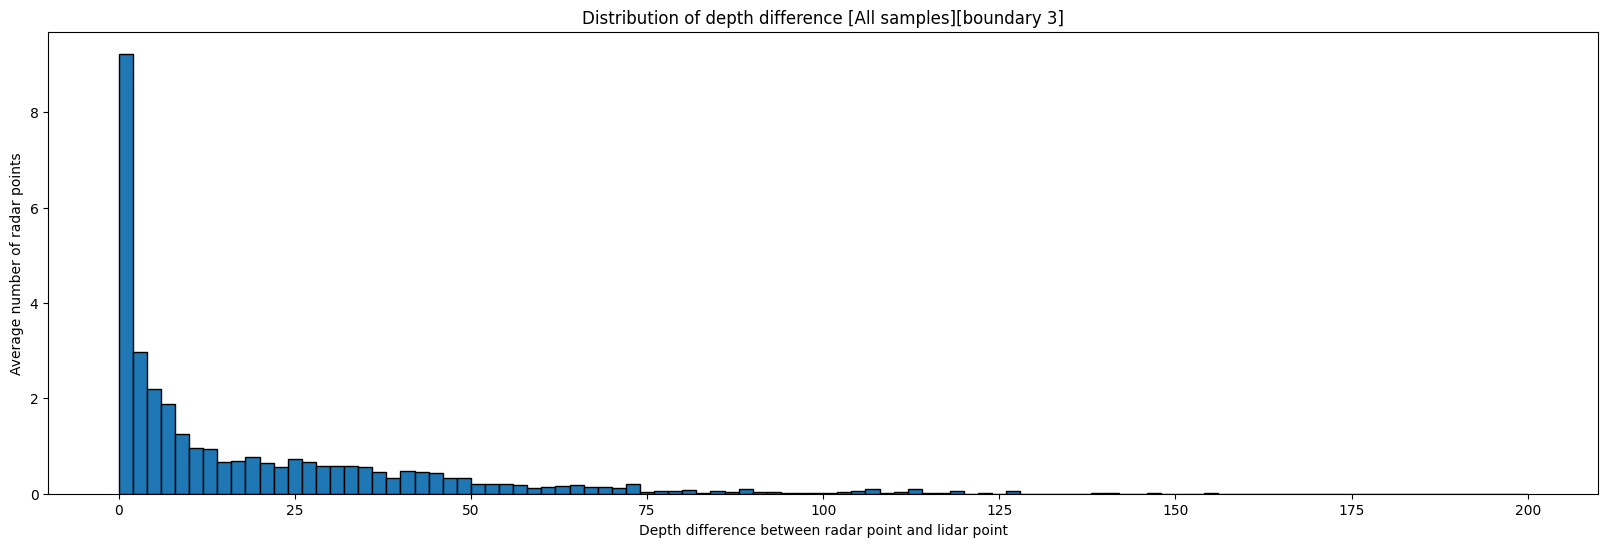

total number of radar pointclouds in 404 samples:  86928
total number of radar pointclouds who has near lidar pointcloud:  13054
total number of radar pointclouds who has no near lidar pointclouds:  73874


In [130]:
total_dis = []
total_diff = []
total_no_pts = 0
boundary_path = 'boundary_'+str(boundary)
base_path = '/home/byounghun/workspace/Nuscenes_tutorial/visualization/Graphs/'
file_name = 'Total_samples.png'

for i in tqdm(range(len(nusc.sample))):
    dis, diff, no_pts = nusc.check_depth(nusc.sample[i]['token'], boundary=boundary)
    total_dis.extend(dis)
    total_diff.extend(diff)
    total_no_pts += no_pts


bins = 100
hist_t, bin_edges_t = np.histogram(total_diff, bins=bins, range=(0,max_range))#, density=True)
hist_t = hist_t / len(nusc.sample)

plt.figure(figsize=(20, 6))
bar_centers = bin_edges_t[:-1] + np.diff(bin_edges_t) / 2
plt.bar(bar_centers, hist_t, width=np.diff(bin_edges_t), edgecolor='black')

plt.xlabel('Depth difference between radar point and lidar point')
plt.ylabel('Average number of radar points')
# plt.ylim(0,20)
# plt.yticks(np.arange(0,21,1))
plt.title('Distribution of depth difference '+'[All samples]' + '[boundary '+ str(boundary) + ']')

out_path = osp.join(base_path,boundary_path,file_name)
# plt.savefig(out_path)
plt.show()
print('total number of radar pointclouds in 404 samples: ', str(len(total_diff)+total_no_pts))
print('total number of radar pointclouds who has near lidar pointcloud: ', str(len(total_diff)))
print('total number of radar pointclouds who has no near lidar pointclouds: ', str(total_no_pts))

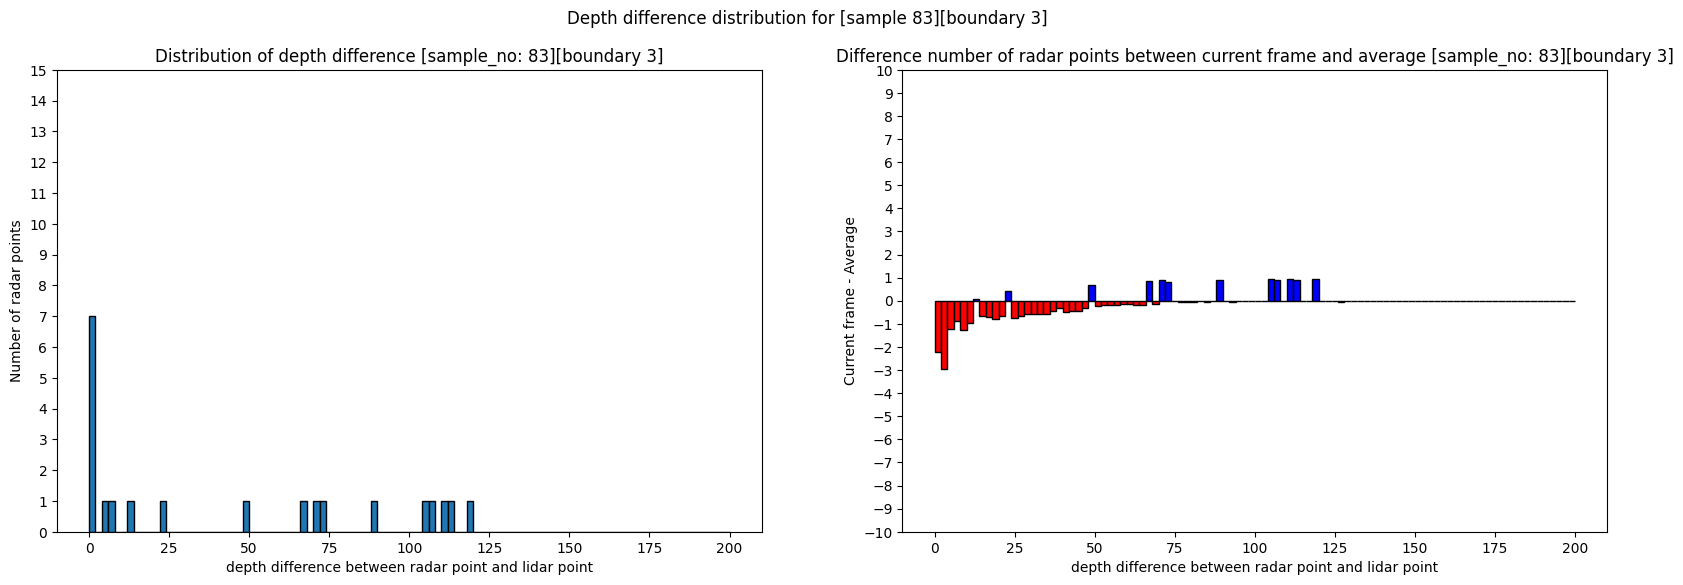

In [139]:
dis, diff, no_pts = nusc.check_depth(nusc.sample[index]['token'], boundary=boundary)
hist, bin_edges = np.histogram(diff, bins=bins, range=(0,max_range))#, density=True)
proportion_difference = hist - hist_t

colors = ['red' if value < 0 else 'blue' for value in proportion_difference]

file_name = 'sample_'+str(index)+'.png'

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
bar_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
axes[0].bar(bar_centers, hist, width=np.diff(bin_edges), edgecolor='black')
axes[0].set_xlabel('depth difference between radar point and lidar point')
axes[0].set_ylabel('Number of radar points')
axes[0].set_ylim(0,15)
axes[0].set_yticks(np.arange(0,16,1))
axes[0].set_title('Distribution of depth difference '+'[sample_no: '+ str(index) + ']'+'[boundary '+ str(boundary) + ']')

axes[1].bar(bar_centers, proportion_difference, color=colors, width=(max_range/bins), edgecolor='black')
axes[1].set_xlabel('depth difference between radar point and lidar point')
axes[1].set_ylabel('Current frame - Average')
axes[1].set_ylim(-10,10)
axes[1].set_yticks(np.arange(-10,11,1))
axes[1].set_title('Difference number of radar points between current frame and average '+'[sample_no: '+ str(index) + ']'+'[boundary '+ str(boundary) + ']')

fig.suptitle('Depth difference distribution for [sample '+str(index)+']'+'[boundary '+ str(boundary) + ']')

out_path = osp.join(base_path,boundary_path,file_name)
plt.tight_layout
plt.show()
# plt.savefig(out_path)
# plt.close()

# Visualize

In [2]:
index = 83
nsweeps = 1

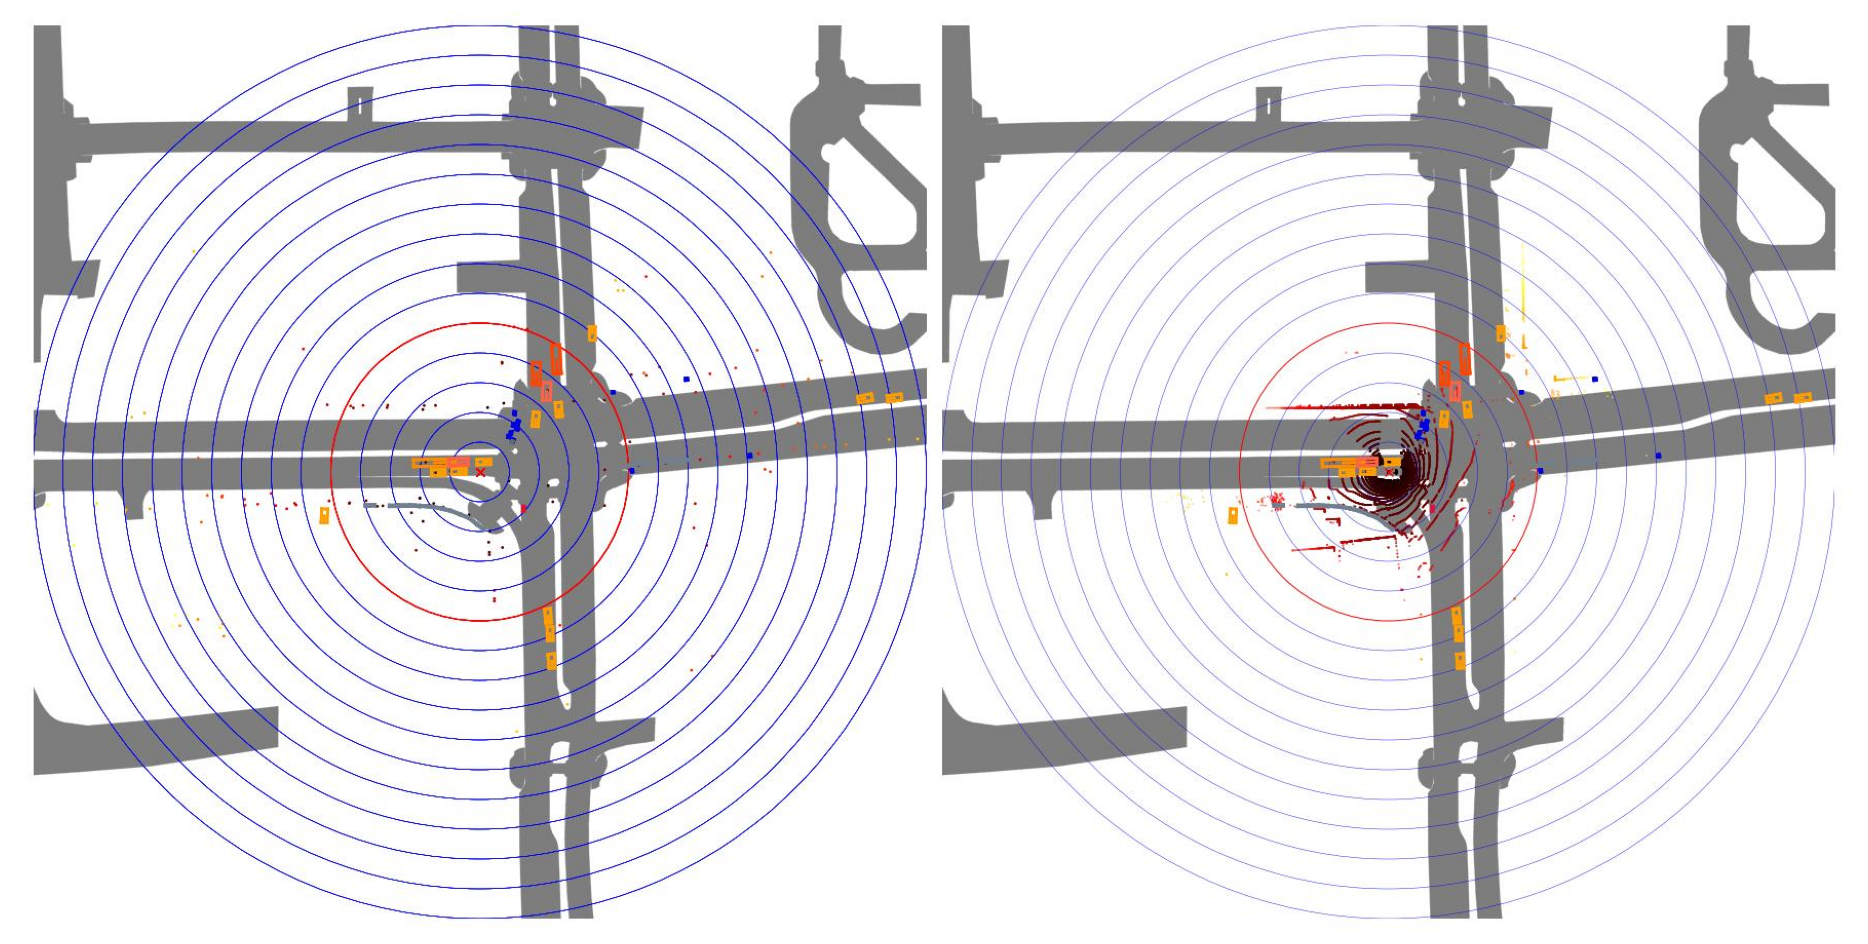

In [3]:
nusc.render_sample_new(nusc.sample[index]['token'], nsweeps=nsweeps,
                       out_path='/home/byounghun/workspace/CRN/sample_bev.jpg',
                       sample_path='/home/byounghun/workspace/CRN/sample.jpg',
                       verbose = True)

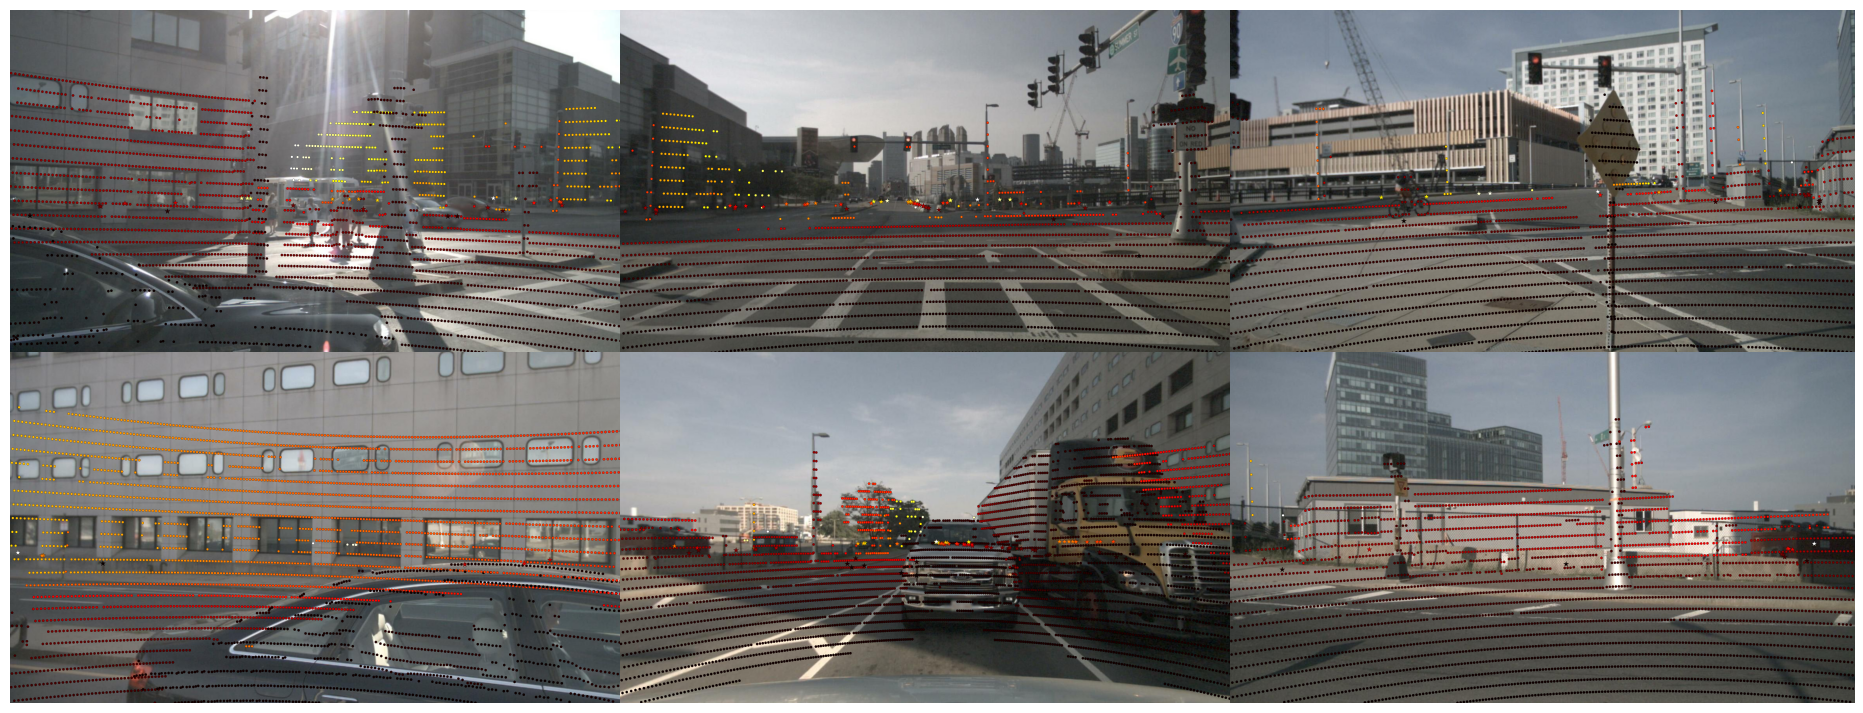

In [4]:
nusc.render_pointcloud_in_scene(nusc.sample[index]['token'], nsweeps = nsweeps, show_both_modality=True, verbose=True)

In [13]:
def visualize_3d(index=0, nsweeps=1, rgb_radar=[1,0,0], rgb_lidar=[0,0,1],
                 size_radar=1, size_lidar=0.1, height=800, width=800):
    # pts
    radar_pc = nusc.make_points_list('r', index, nsweeps=nsweeps).astype(np.float32)
    lidar_pc = nusc.make_points_list('l', index, nsweeps=nsweeps).astype(np.float32)

    # radar pc
    radar_points_buf = pjs.BufferAttribute(array=radar_pc)
    radar_colors_buf = pjs.BufferAttribute(array=np.array([rgb_radar] * len(radar_pc), dtype=np.float32))
    radar_geometry = pjs.BufferGeometry(attributes={'position': radar_points_buf, 'color': radar_colors_buf})
    radar_material = pjs.PointsMaterial(vertexColors='VertexColors', size=size_radar)
    radar_pointCloud = pjs.Points(geometry=radar_geometry, material=radar_material)

    # lidar pc
    lidar_points_buf = pjs.BufferAttribute(array=lidar_pc)
    lidar_colors_buf = pjs.BufferAttribute(array=np.array([rgb_lidar] * len(lidar_pc), dtype=np.float32))
    lidar_geometry = pjs.BufferGeometry(attributes={'position': lidar_points_buf, 'color': lidar_colors_buf})
    lidar_material = pjs.PointsMaterial(vertexColors='VertexColors', size=size_lidar)
    lidar_pointCloud = pjs.Points(geometry=lidar_geometry, material=lidar_material)

    pythreejs_camera = pjs.PerspectiveCamera(up=[1, 0, 1], children=[pjs.DirectionalLight(color='black', intensity=0.5)])
    pythreejs_camera.rotateX(np.pi/4)
    pythreejs_camera.position = (-15., 0., 30.)

    sphere_geometry = pjs.SphereGeometry(radius=51.2, widthSegments=32, heightSegments=16)
    sphere_material = pjs.MeshBasicMaterial(color='red', transparent=True, opacity=0.05)
    
    scene = pjs.Scene(children=[radar_pointCloud, lidar_pointCloud, pythreejs_camera, pjs.AmbientLight(color='#777777')])
    axes = pjs.AxesHelper(size=3)
    sphere = pjs.Mesh(geometry=sphere_geometry, material=sphere_material)
    scene.add(axes)
    scene.add(sphere)
        
    control = pjs.OrbitControls(controlling=pythreejs_camera)
    renderer = pjs.Renderer(camera=pythreejs_camera, scene=scene, width=width, height=height, preserveDrawingBuffer=True, controls=[control])
    
    return renderer


In [14]:
renderer = visualize_3d(index=index, nsweeps=nsweeps, size_radar=1, size_lidar=0.1)
renderer

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='black', intensity=0.5, position=(0.0, 0.0,…

# Find index of validation dataset

In [1]:
with open('/home/byounghun/workspace/CRN/data/nuScenes/nuscenes_infos_val.pkl', 'rb') as f:
	val_data = pickle.load(f)
with open('/home/byounghun/workspace/CRN/data/nuScenes/nuscenes_infos_train.pkl', 'rb') as f:
	train_data = pickle.load(f)
    
val_sample_list = [d['sample_token'] for d in val_data]
train_sample_list = [d['sample_token'] for d in train_data]

print(len(train_sample_list))
print(len(val_sample_list))
# val_sample_list

28130
6019


In [26]:
mini_sample_token_list = [sample['token'] for sample in nusc.sample]
val_idx_dict = {}
train_idx_dict = {}

for mini_sample in mini_sample_token_list:
    if mini_sample in val_sample_list:
        idx = val_sample_list.index(mini_sample)
        idx_mini = mini_sample_token_list.index(mini_sample)
        val_idx_dict[idx_mini] = idx
    elif mini_sample in train_sample_list:
        idx = train_sample_list.index(mini_sample)
        idx_mini = mini_sample_token_list.index(mini_sample)
        train_idx_dict[idx_mini] = idx

print(len(val_idx_dict))
print(len(train_idx_dict))

162
242


In [27]:
with open('/home/byounghun/workspace/CRN/val_idx_dict.pkl','wb') as f:
    pickle.dump(val_idx_dict, f)
with open('/home/byounghun/workspace/CRN/train_idx_dict.pkl','wb') as f:
    pickle.dump(train_idx_dict, f)

In [34]:
with open('/home/byounghun/workspace/CRN/val_idx_dict.pkl', 'rb') as f:
    val_idx_dict = pickle.load(f)
with open('/home/byounghun/workspace/CRN/train_idx_dict.pkl', 'rb') as f:
    train_idx_dict = pickle.load(f)

In [37]:
train_idx_dict[20]

1848

# Feature Map

In [1]:
index=83
nsweeps=1

In [14]:
# 83 - bad, 203 - good
fused_feature_map_list = []
base_feat_path = '/home/byounghun/workspace/CRN/feature_map'
for i in range(4):
    file_name = 'ret_feature_list_np_' + str(i) + '.npy'
    feature_map = np.load(osp.join(base_feat_path, file_name))
    fused_feature_map_list.append(feature_map)
print(len(fused_feature_map_list))
# fused_feature_map_list

4


In [15]:
# fused feature map after multi-modal deformable attention
fused_feature_map = fused_feature_map_list[0]
# fused_feature_map

In [16]:
image_feature_map = np.load(osp.join(base_feat_path, 'img_feature_map_np.npy'))
radar_feature_map = np.load(osp.join(base_feat_path, 'radar_feature_map_np.npy'))

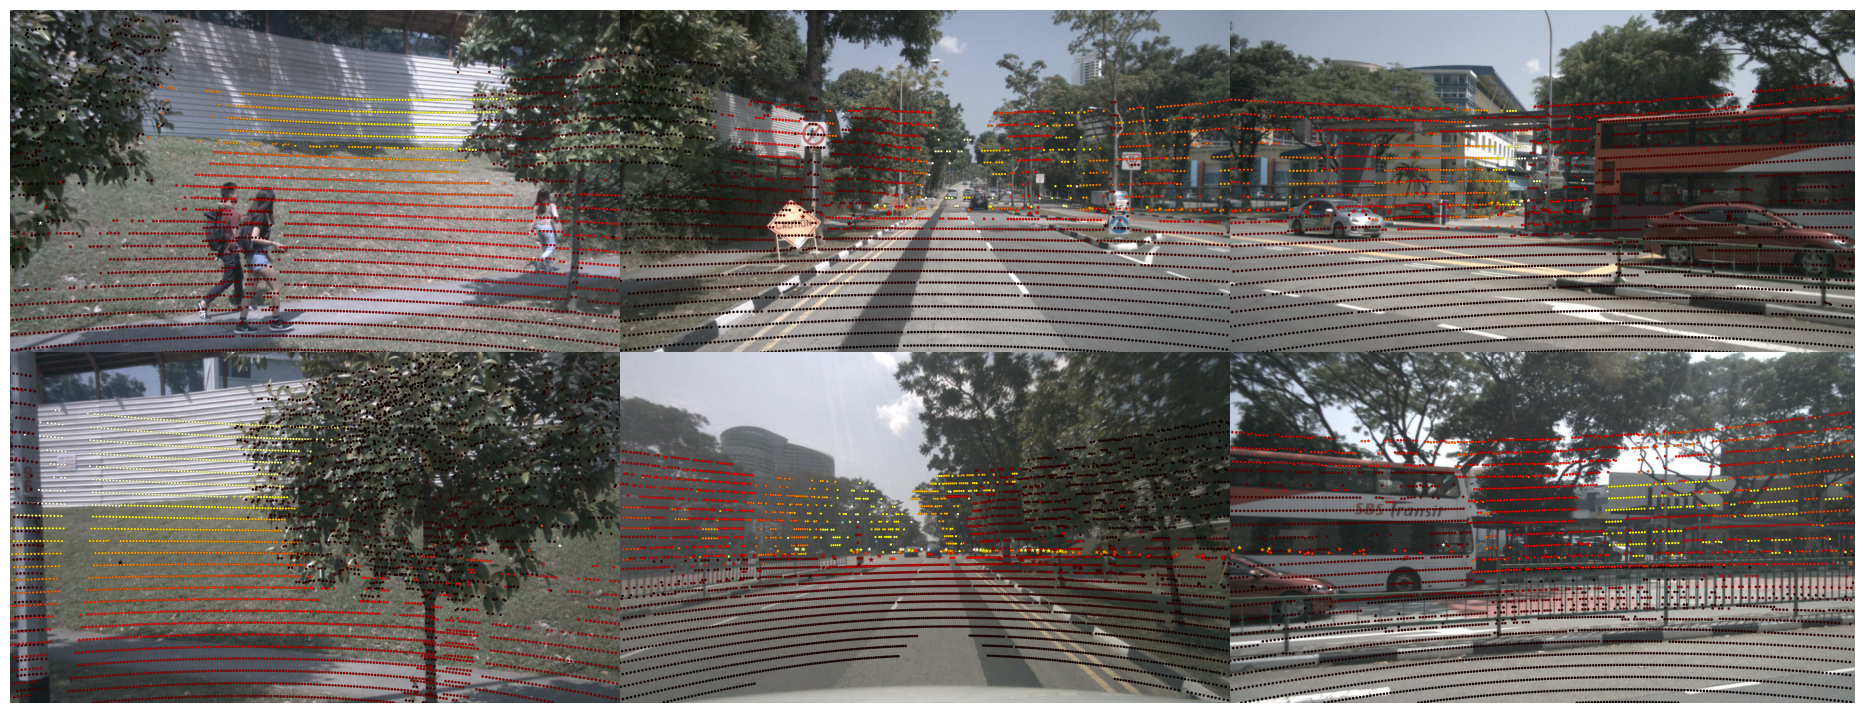

In [17]:
nusc.render_pointcloud_in_scene(nusc.sample[index]['token'], nsweeps = nsweeps, show_both_modality=True, verbose=True)

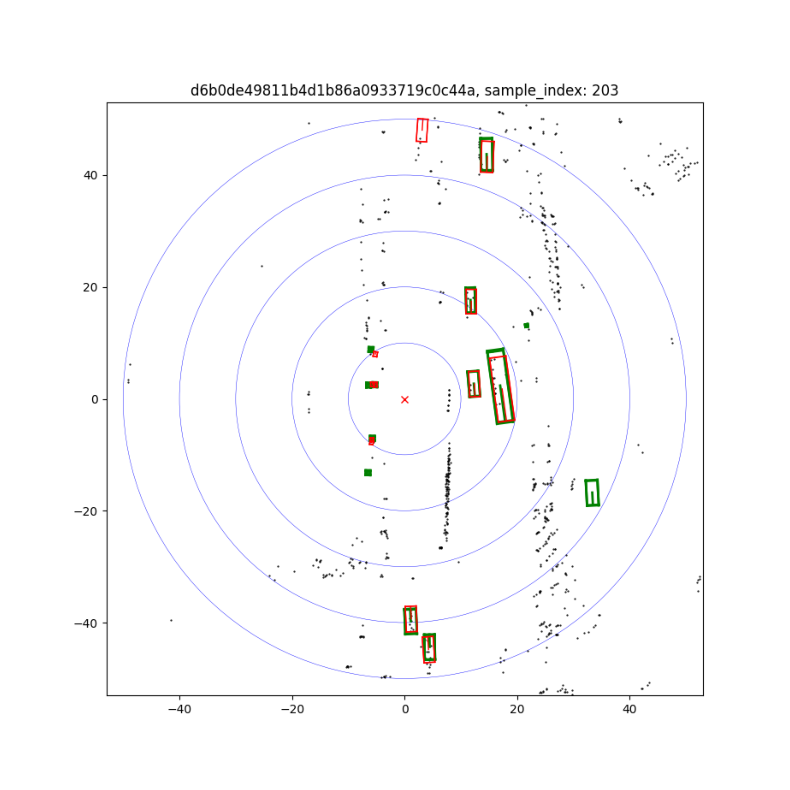

In [18]:
image_name = str(nusc.get('sample',nusc.sample[index]['token'])['timestamp'])+'.png'

pred_result = plt.imread(osp.join('/home/byounghun/workspace/CRN/outputs/det/CRN_r18_256x704_128x128_4key/examples',image_name))
plt.figure(figsize=(10, 10))
plt.imshow(pred_result)
plt.axis('off')
plt.show()

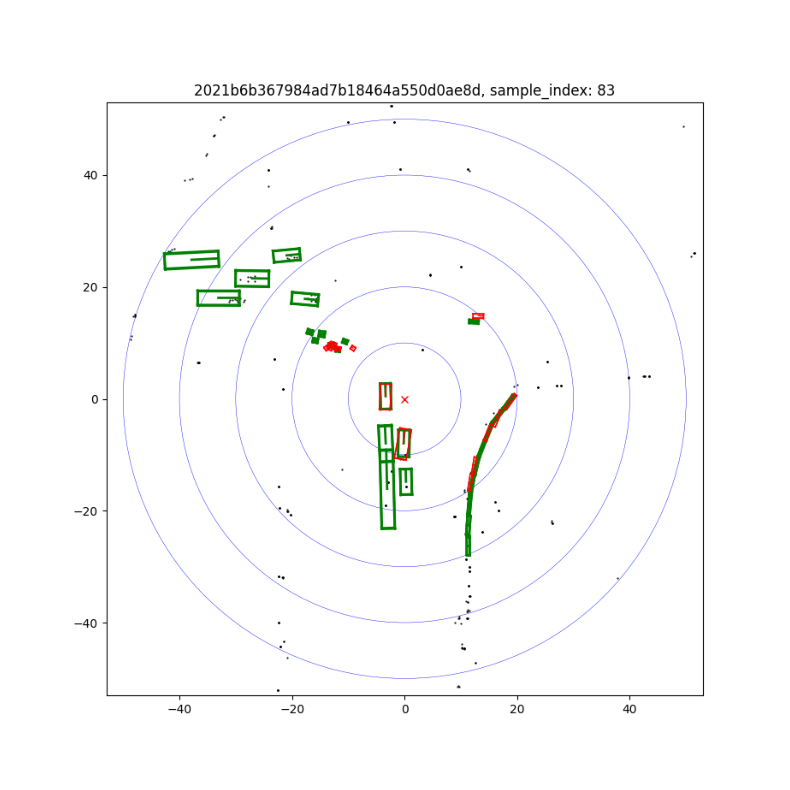

In [4]:
# BEVDepth

image_name = str(nusc.get('sample',nusc.sample[index]['token'])['timestamp'])+'.png'

pred_result = plt.imread(osp.join('/home/byounghun/workspace/BEVDepth/outputs/bev_depth_lss_r50_256x704_128x128_24e_2key/examples',image_name))
plt.figure(figsize=(10, 10))
plt.imshow(pred_result)
plt.axis('off')
plt.show()

In [60]:
base_file_path = '/home/byounghun/workspace/CRN/bbox_infos'
file_n_gt = 'boxes_gt_' + str(index) + '.pkl'
file_n_est = 'boxes_est_' + str(index) + '.pkl'

with open(osp.join(base_file_path, file_n_gt), 'rb') as f:
    boxes_gt = pickle.load(f)
with open(osp.join(base_file_path, file_n_est), 'rb') as f:
    boxes_est = pickle.load(f)
print(boxes_gt[0])
print(boxes_est[0])

label: nan, score: nan, xyz: [33.33, -16.80, -1.52], wlh: [2.07, 4.46, 1.62], rot axis: [0.03, 0.03, -1.00], ang(degrees): 87.13, ang(rad): 1.52, vel: nan, nan, nan, name: None, token: None
label: nan, score: 0.90, xyz: [-5.22, 2.52, -1.59], wlh: [0.67, 0.82, 1.71], rot axis: [0.01, -0.01, 1.00], ang(degrees): 95.53, ang(rad): 1.67, vel: nan, nan, nan, name: None, token: None


In [61]:
def draw_corners(ax, boxes, color='green', linewidth=1, th=0.5):
    original_min, original_max = -51.2, 51.2
    original_range = original_max - original_min
    target_min, target_max = 0, 128
    target_range = target_max - target_min

    scale_factor = target_range / original_range
    
    rot_mat = np.array([
    [-1,0,0,0],
    [0,-1,0,0],
    [0,0,1,0],
    [0,0,0,1]])
    
    if not np.isnan(boxes[0].score):
        homo_corners = [np.vstack((box.corners(), np.ones((1, 8)))) for box in boxes if box.score > th]
    else:
        homo_corners = [np.vstack((box.corners(), np.ones((1, 8)))) for box in boxes]
        
    rot_corners_list = [np.dot(homo.T, rot_mat)[:,:3] for homo in homo_corners]
    rot_corners_list_neg_y = [np.array([[-x, y, z] for [x, y, z] in corners]) for corners in rot_corners_list]
    scaled_corners = [np.array([[(x - original_min) * scale_factor,
                                 (y - original_min) * scale_factor,
                                 (z - original_min) * scale_factor] for [x,y,z] in corners]) for corners in rot_corners_list_neg_y]
    for rot_corners in scaled_corners:
        for i in range(4):
            ax.plot([rot_corners[i][0], rot_corners[i + 4][0]],
                      [rot_corners[i][1], rot_corners[i + 4][1]],
                      color=color, linewidth=linewidth)
        def draw_rect(ax, selected_corners, color, linewidth):
            prev = selected_corners[-1]
            for corner in selected_corners:
                ax.plot([prev[0], corner[0]], [prev[1], corner[1]], color=color, linewidth=linewidth)
                prev = corner
        draw_rect(ax, rot_corners[:4], color, linewidth)
        draw_rect(ax, rot_corners[4:], color, linewidth)

        center_bottom_forward = np.mean(rot_corners[2:4], axis=0)
        center_bottom = np.mean(rot_corners[[2, 3, 7, 6]], axis=0)
        ax.plot([center_bottom[0], center_bottom_forward[0]],
                  [center_bottom[1], center_bottom_forward[1]],
                  color=color, linewidth=linewidth)

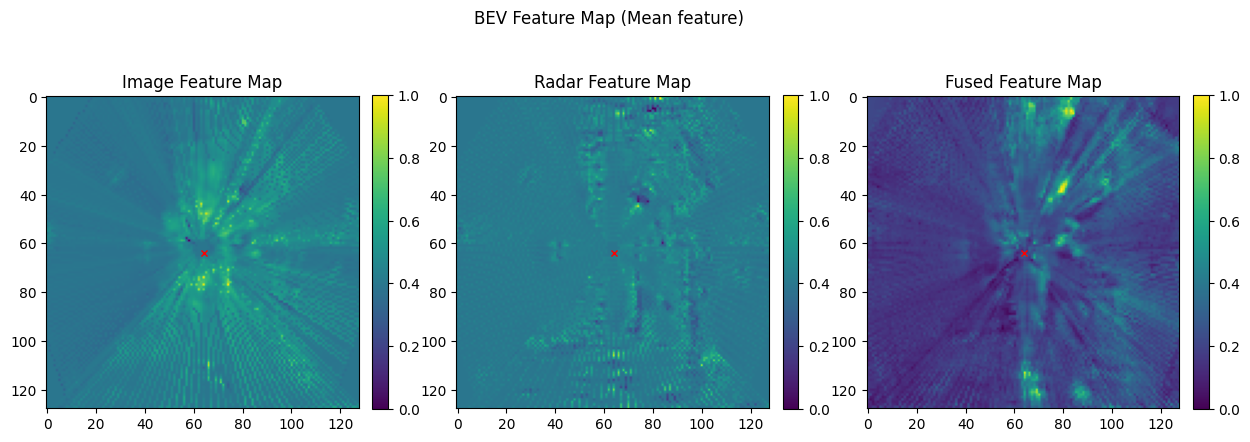

In [62]:
# 초기 설정
th = 0.5
linewidth_gt = 0.5
linewidth_est = 0.3
color_gt = 'black'
color_est = 'red'
axes_limit = 127.5
draw_bbox = False

# 모든 feature channel에서 mean값 계산하여 2D BEV map 생성
image_feature_map_mean = np.mean(image_feature_map[0, :, :, :], axis=0)
image_feature_map_mean_normalized = (image_feature_map_mean - np.min(image_feature_map_mean)) / (np.max(image_feature_map_mean) - np.min(image_feature_map_mean))
image_rotated_map = np.rot90(image_feature_map_mean_normalized, k=1)
image_mirrored_map = image_rotated_map[:, ::-1]

radar_feature_map_mean = np.mean(radar_feature_map[0, :, :, :], axis=0)
radar_feature_map_mean_normalized = (radar_feature_map_mean - np.min(radar_feature_map_mean)) / (np.max(radar_feature_map_mean) - np.min(radar_feature_map_mean))
radar_rotated_map = np.rot90(radar_feature_map_mean_normalized, k=1)
radar_mirroed_map = radar_rotated_map[:, ::-1]

fused_feature_map_mean = np.mean(fused_feature_map[0, :, :, :], axis=0)
fused_feature_map_mean_normalized = (fused_feature_map_mean - np.min(fused_feature_map_mean)) / (np.max(fused_feature_map_mean) - np.min(fused_feature_map_mean))
fused_rotated_map = np.rot90(fused_feature_map_mean_normalized, k=1)
fused_mirrored_map = fused_rotated_map[:, ::-1]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

im0 = axes[0].imshow(image_mirrored_map, cmap='viridis')
axes[0].plot(64, 64, marker='x', color='red', markersize=5)
axes[0].set_title('Image Feature Map')
axes[0].set_xlim(-0.5, axes_limit)
axes[0].set_ylim(axes_limit, -0.5)
# axes[0].axis('off')
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(radar_mirroed_map, cmap='viridis')
axes[1].set_title('Radar Feature Map')
axes[1].plot(64, 64, marker='x', color='red', markersize=5)
axes[1].set_xlim(-0.5, axes_limit)
axes[1].set_ylim(axes_limit, -0.5)
# axes[1].axis('off')
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

im2 = axes[2].imshow(fused_mirrored_map, cmap='viridis')
axes[2].set_title('Fused Feature Map')
axes[2].plot(64, 64, marker='x', color='red', markersize=5)
axes[2].set_xlim(-0.5, axes_limit)
axes[2].set_ylim(axes_limit, -0.5)
# # axes[2].axis('off')
fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

if draw_bbox == True:
    draw_corners(axes[0], boxes_gt, color=color_gt, linewidth=linewidth_gt, th=th)
    draw_corners(axes[0], boxes_est, color=color_est, linewidth=linewidth_est, th=th)
    draw_corners(axes[1], boxes_gt, color=color_gt, linewidth=linewidth_gt, th=th)
    draw_corners(axes[1], boxes_est, color=color_est, linewidth=linewidth_est, th=th)
    draw_corners(axes[2], boxes_gt, color=color_gt, linewidth=linewidth_gt, th=th)
    draw_corners(axes[2], boxes_est, color=color_est, linewidth=linewidth_est, th=th)

plt.suptitle('BEV Feature Map (Mean feature)')
plt.savefig('/home/byounghun/workspace/CRN/feature_map/BEV_Feature_Map.png')
plt.show()

# Distance distribution

In [10]:
index = [20]

In [11]:
radar_distance_total = []
lidar_distance_total = []

for i in tqdm(range(len(index))):
    radar_pc = nusc.make_points_list('r', i, nsweeps=1).astype(np.float32)
    lidar_pc = nusc.make_points_list('l', i, nsweeps=1).astype(np.float32)

    radar_distance = [mt.sqrt(mt.pow(radar_pc[i][0], 2) + mt.pow(radar_pc[i][1], 2) + mt.pow(radar_pc[i][2], 2)) for i in range(len(radar_pc))]
    lidar_distance = [mt.sqrt(mt.pow(lidar_pc[i][0], 2) + mt.pow(lidar_pc[i][1], 2) + mt.pow(lidar_pc[i][2], 2)) for i in range(len(lidar_pc))]

    radar_distance_total.extend(radar_distance)
    lidar_distance_total.extend(lidar_distance)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.46it/s]


Text(0.5, 1.0, 'number of lidar pointcloud in mini samples')

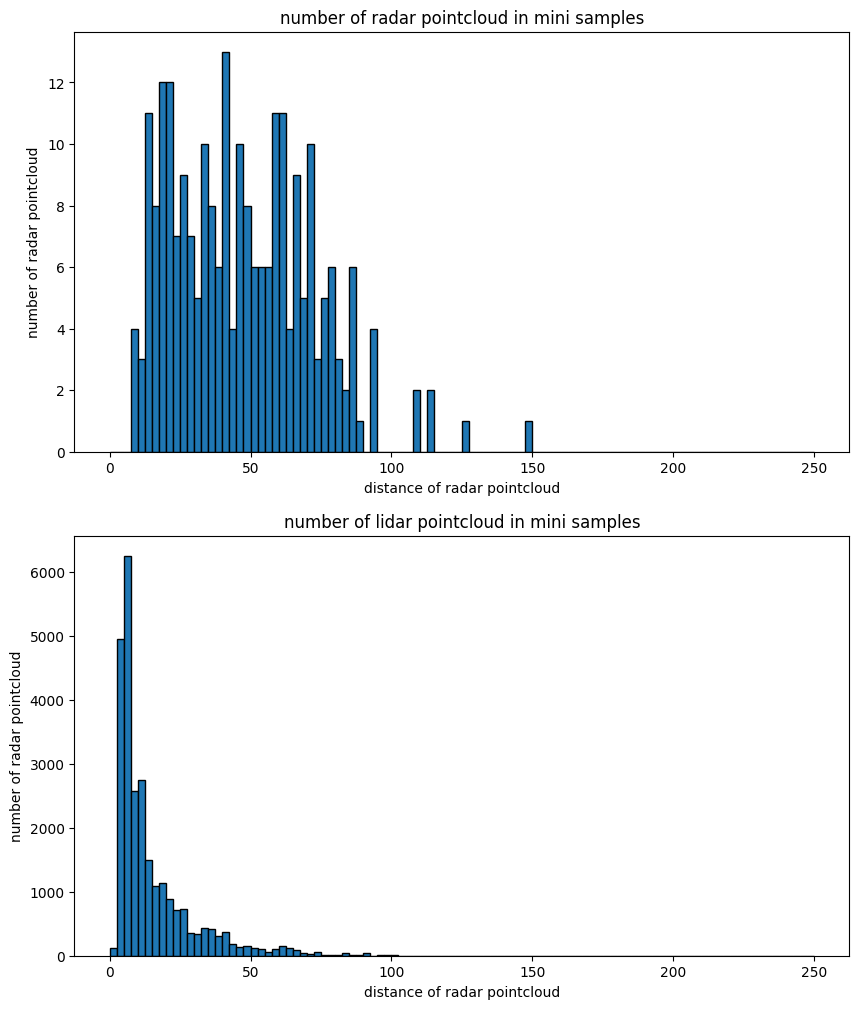

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,12))
bins = 100
hist_r, bin_edges_r = np.histogram(radar_distance_total, bins=bins, range=(0,250))#, density=True)
hist_l, bin_edges_l = np.histogram(lidar_distance_total, bins=bins, range=(0,250))#, density=True)

bar_centers_r = bin_edges_r[:-1] + np.diff(bin_edges_r) / 2
axes[0].bar(bar_centers_r, hist_r, width=np.diff(bin_edges_r), edgecolor='black')

bar_centers_l = bin_edges_l[:-1] + np.diff(bin_edges_l) / 2
plt.bar(bar_centers_l, hist_l, width=np.diff(bin_edges_l), edgecolor='black')

axes[0].set_xlabel('distance of radar pointcloud')
axes[0].set_ylabel('number of radar pointcloud')
# plt.ylim(0,20)
# plt.yticks(np.arange(0,21,1))
axes[0].set_title('number of radar pointcloud in mini samples')

axes[1].set_xlabel('distance of radar pointcloud')
axes[1].set_ylabel('number of radar pointcloud')
# plt.ylim(0,20)
# plt.yticks(np.arange(0,21,1))
axes[1].set_title('number of lidar pointcloud in mini samples')

In [13]:
count = 0
for distance in radar_distance_total:
    if distance > 51.2:
        count += 1
long_range_percentage_radar = count*100/len(radar_distance_total)
long_range_percentage_radar

41.90871369294606

In [14]:
count = 0
for distance in lidar_distance_total:
    if distance > 51.2:
        count += 1
long_range_percentage_lidar = count*100/len(lidar_distance_total)
long_range_percentage_lidar

3.725297190883622